<a href="https://colab.research.google.com/github/xwy031xwy/Estimation-of-online-shopping-user-behavior/blob/main/online_shopping_intention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

# 読み込み

In [ ]:
# Import packages

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

# Read data and display data head

shopping = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project3A/online_shoppers_intention.csv')
shopping.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
shopping.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


## Quote
Note 1:

As "Page Values" follows specific calculating methods in Google Analytics, we put it here for you to understand this feature better:

Function:

Page Value = (Ecommerce Revenue + Total Goal Value)/ Number of Unique Pageviews for Given Page

Example:

1) Supposing your purchase path on this website go through: Page A, B, C, B, D (Goal Page), E (Receipt Page). What we want to calculate is the page value of page B, which you have visited 2 times (but only considered as 1 unique page view).

2) Ecommerce Revenue: How much a consumer pays -> we assume 100 here (value from ecommerce transaction on Page E)

3) Total Goal Value: Goal value is assigned to Goal Page D by website at he beginning, we assume 10 here; and total goal value is goal value unique pageviews of Page B, which is 1 10 = 10 here

4) Page Value of Page B (each click) = (100+ 1 * 10) / 1 = 110

Application in this case

We don't have page value for an exact page, instead, we only have average page value of all visited pages by customer.

Note 2:

To avoid misunderstanding, the bounce rate and exit rate don't mean 1 customer's bounce/exit rate. Each page's bounce/exit rate is calculated based on all historical visits of past visitors; and the bounce/exit rate we see here in each line refers to the average rate of all pages 1 customer visited.

Note 3:

Regarding "Month", we don't have data from January and April, but we assume it's a complete dataset for 1 whole year sales.


In [ ]:
shopping.std()

Administrative                3.321784
Administrative_Duration     176.779107
Informational                 1.270156
Informational_Duration      140.749294
ProductRelated               44.475503
ProductRelated_Duration    1913.669288
BounceRates                   0.048488
ExitRates                     0.048597
PageValues                   18.568437
SpecialDay                    0.198917
OperatingSystems              0.911325
Browser                       1.717277
Region                        2.401591
TrafficType                   4.025169
Weekend                       0.422509
Revenue                       0.361676
dtype: float64

In [ ]:
# Check for null values in data
nullcount = shopping.isnull().sum()
print('Total number of null values in dataset:', nullcount.sum())

Total number of null values in dataset: 0


## 相関ヒートマップ

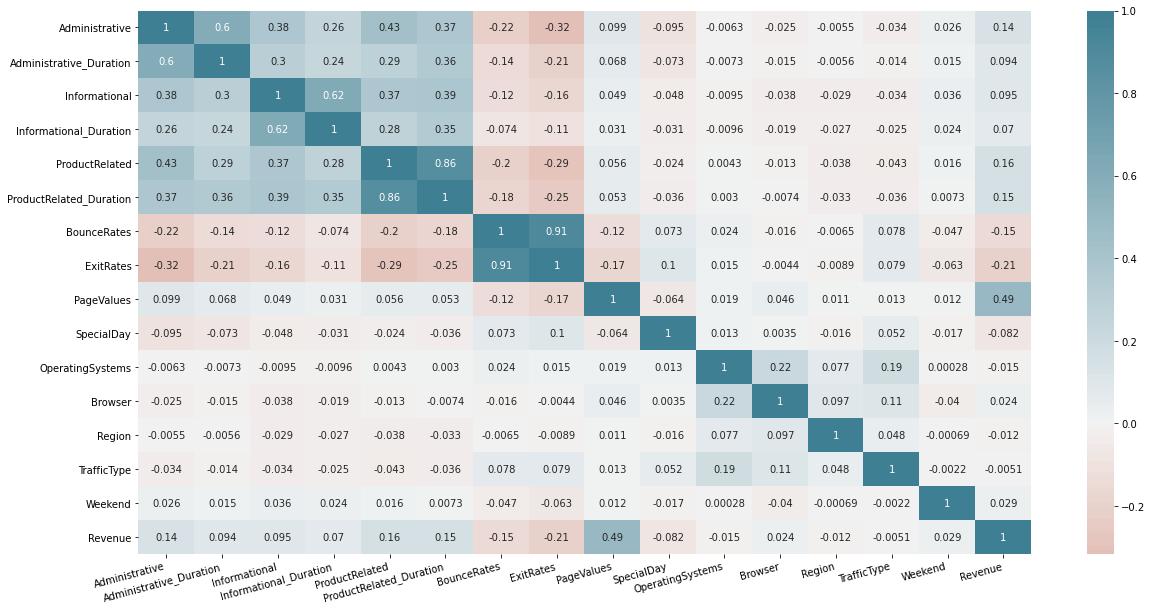

In [ ]:
plt.figure(figsize=(20,10))
heatmap = sns.heatmap(shopping.corr(),cmap=sns.diverging_palette(20, 220, n=200),center = 0,annot=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=15,horizontalalignment='right');

# 前処理

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


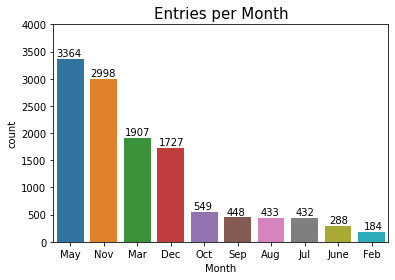

In [ ]:
monthly = shopping['Month'].value_counts()

sns.countplot(shopping['Month'], order=monthly.index)
plt.title('Entries per Month', fontsize=15)
xval = -.42
plt.ylim(0,4000)

for index, value in monthly.items():
    plt.text(x=xval, y=value+50, s=str(value))
    xval += 1.02

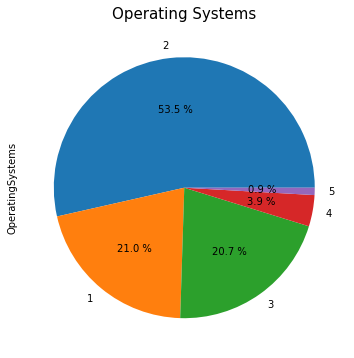

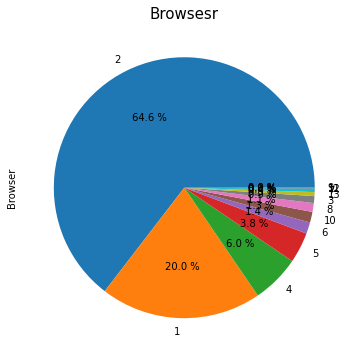

In [ ]:
shopping['OperatingSystems'] = shopping['OperatingSystems'].replace([5,6,7,8],5)
os_plot = shopping['OperatingSystems'].value_counts().plot.pie(figsize=(6,6) , autopct="%1.1f %%")
plt.title('Operating Systems', fontsize=15)
plt.show()

plot = shopping['Browser'].value_counts().plot.pie(figsize=(6,6), autopct="%1.1f %%")
plt.title('Browsesr', fontsize=15)
plt.show()


## ドロップ

In [ ]:
shopping = shopping.drop(['Month','Browser','OperatingSystems','Region','TrafficType','ExitRates'], axis=1) #,'Weekend'

## Encode

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in ['VisitorType', 'Weekend', 'Revenue']:
    le.fit(shopping[column])
    shopping[column] = le.transform(shopping[column])



In [ ]:
shopping['Revenue']



*   Return 2
*   other 1
*   new 0





## 2分割

In [ ]:
# Split train and test data

X = shopping.drop('Revenue', axis=1)
y = shopping['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=2, test_size=.2)

In [ ]:
X_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,PageValues,SpecialDay,VisitorType,Weekend
6183,0,0.000000,0,0.0,3,50.400000,0.000000,0.000000,0.0,2,0
9253,9,65.166667,0,0.0,123,5969.573168,0.001538,10.692380,0.0,0,0
2927,0,0.000000,1,44.0,14,549.500000,0.000000,43.252000,0.2,0,0
7192,7,204.100000,0,0.0,5,128.700000,0.000000,0.000000,0.0,0,0
3869,2,25.500000,0,0.0,13,908.500000,0.000000,19.785333,0.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
2514,2,40.000000,0,0.0,21,1494.500000,0.009091,0.000000,0.0,2,0
11798,0,0.000000,0,0.0,6,81.750000,0.000000,0.000000,0.0,2,0
6637,0,0.000000,0,0.0,28,527.833333,0.029630,0.000000,0.0,2,0
2575,1,13.000000,0,0.0,13,220.333333,0.000000,0.000000,0.0,2,0


# XGBoost

正解率（accuracy）: accuracy_score()
適合率（precision）: precision_score()
再現率（recall）: recall_score()



In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

### チューニング

In [ ]:
cv_params = {'n_estimators': [400, 500, 600, 700, 800], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6], 
             'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9], 
             'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3], 'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('best parameters：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 2880000 candidates, totalling 14400000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   41.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 22.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 36.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 54.8min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 67.6min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 85.9min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 112.7min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 130.9min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 160.2min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 185.4min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 219.7min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 2

In [ ]:


"""
for depth in [5, 10, 15, 20]:
  for n in [10, 20, 30, 40, 50, 60]:
    model = XGBClassifier(max_depth=depth, n_estimators=n, random_state = 70)
    model.fit(X_train, y_train)
    #xgb.plot_tree(model)
    pred = model.predict(X_test)
    common = (y_test.values == pred).sum()
    # print(common)
    #print(positive)
    predict = len(pred)
    # print(predict)
    print(depth, n)
    print('Precision:', precision_score(y_test,pred))
    print('Recall:', recall_score(y_test,pred))
    print('Accuracy:',accuracy_score(y_test,pred))positive = len(y_test.values)
    


print('precision = ' + str(common / predict))
print('recall = ' + str(common / positive))
print('accuracy = ' + str((100 - (positive + predict - common) + common) / 100))

"""



model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.3min finished


[15:36:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
每轮迭代运行结果:{'mean_fit_time': array([ 8.3068017 , 10.31001129, 12.27598562, 14.33648024, 14.15485635]), 'std_fit_time': array([0.06272563, 0.0814575 , 0.14202038, 0.21421893, 3.45205685]), 'mean_score_time': array([0.08496962, 0.10292387, 0.12661424, 0.15381298, 0.12825842]), 'std_score_time': array([0.00860016, 0.00408228, 0.00723872, 0.00886459, 0.04743847]), 'param_n_estimators': masked_array(data=[400, 500, 600, 700, 800],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 400}, {'n_estimators': 500}, {'n_estimators': 600}, {'n_estimators': 700}, {'n_estimators': 800}], 'split0_test_score': array([0.53774433, 0.52665512, 0.52317523, 0.51384337, 0.50957574]), 'split1_test_score': array([0.49920349, 0.48846852, 0.47750381, 0.46354451, 0.45432799]), 'split2_test_score': array([0.451

### （別々）チューニング

In [ ]:
"""
cv_params = {'n_estimators': [400, 500, 600, 700, 800]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 3, 'min_child_weight': 5, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}
other_params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 3, 'min_child_weight': 5, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.6, 'reg_alpha': 0, 'reg_lambda': 1}
                 cv_params = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
other_params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 3, 'min_child_weight': 5, 'seed': 0,
                'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.6, 'reg_alpha': 0, 'reg_lambda': 1}
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 3, 'min_child_weight': 5, 'seed': 0,
                'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.6, 'reg_alpha': 3, 'reg_lambda': 0.05}

model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('best score:{0}'.format(optimized_GBM.best_score_))
"""

In [ ]:
"""
model = XGBClassifier(learning_rate=0.1, n_estimators=400, max_depth=3, min_child_weight=5, seed=0,
                subsample=0.9, colsample_bytree=0.9, gamma=0.6, reg_alpha=3, reg_lambda=0.05)
model.fit(X_train, y_train)
#xgb.plot_tree(model)
pred = model.predict(X_test)
common = (y_test.values == pred).sum()
# print(common)
#print(positive)
predict = len(pred)
# print(predict)
print(depth, n)
print('Precision:', precision_score(y_test,pred))
print('Recall:', recall_score(y_test,pred))
print('Accuracy:',accuracy_score(y_test,pred))"""

10 10
Precision: 0.7
Recall: 0.4251012145748988
Accuracy: 0.8483373884833739


# RF

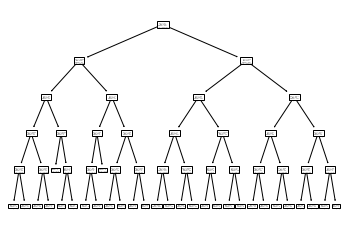

5 10
Precision: 0.7766497461928934
Recall: 0.3097165991902834
Accuracy: 0.8438767234387672


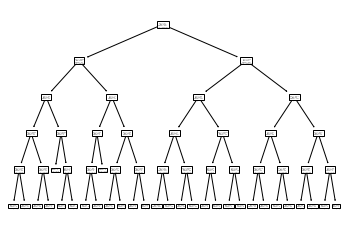

5 20
Precision: 0.7741935483870968
Recall: 0.340080971659919
Accuracy: 0.8479318734793188


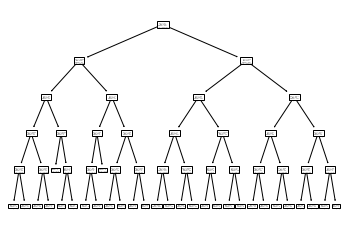

5 30
Precision: 0.7665198237885462
Recall: 0.3522267206477733
Accuracy: 0.8487429034874291


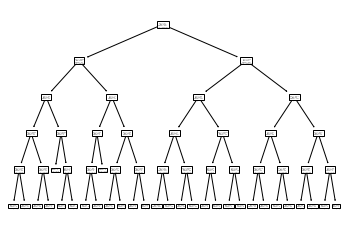

5 40
Precision: 0.7532467532467533
Recall: 0.3522267206477733
Accuracy: 0.8471208434712084


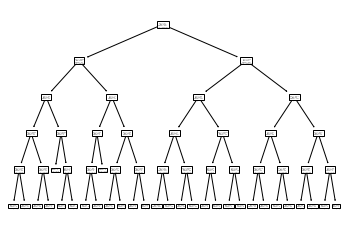

5 50
Precision: 0.759656652360515
Recall: 0.3582995951417004
Accuracy: 0.8487429034874291


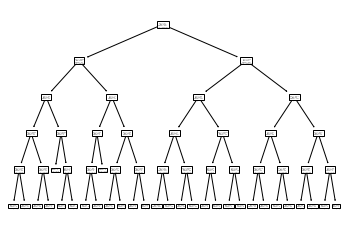

5 60
Precision: 0.7478991596638656
Recall: 0.3603238866396761
Accuracy: 0.8475263584752636


KeyboardInterrupt: ignored

In [ ]:
from sklearn.tree import plot_tree
for depth in [5, 10, 15, 20]:
  for n in [10, 20, 30, 40, 50, 60]:
    model = RandomForestClassifier(max_depth=depth, n_estimators=n,random_state=2 )
    model.fit(X_train, y_train)
    plot_tree(model.estimators_[0])
    plt.show()
    pred = model.predict(X_test)
    #print(pred)
    common = (y_test.values == pred).sum()
    #print(common)
    positive = len(y_test.values)
    #print(positive)
    predict = len(pred)
    #print(predict)
    print(depth, n)
    print('Precision:', precision_score(y_test,pred))
    print('Recall:', recall_score(y_test,pred))
    print('Accuracy:',accuracy_score(y_test,pred))

# print('precision = ' + str(common / predict))
# print('recall = ' + str(common / positive))
# print('accuracy = ' + str((100 - (positive + predict - common) + common) / 100))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
 
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
 
 
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)
 
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.4min finished


{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 306}

In [ ]:
model = RandomForestClassifier(bootstrap = False, max_depth=80, max_features='auto', n_estimators=100 )
model.fit(X_train, y_train)
#plot_tree(model.estimators_[0])
plt.show()
pred = model.predict(X_test)
#print(pred)
common = (y_test.values == pred).sum()
#print(common)
positive = len(y_test.values)
#print(positive)
predict = len(pred)
#print(predict)
print(depth, n)
print('Precision:', precision_score(y_test,pred))
print('Recall:', recall_score(y_test,pred))
print('Accuracy:',accuracy_score(y_test,pred))


10 10
Precision: 0.7142857142857143
Recall: 0.4352226720647773
Accuracy: 0.8519870235198702


# NN

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                600       
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               6120      
_________________________________________________________________
dropout_7 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 242       
Total params: 6,962
Trainable params: 6,962
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - 1s 32ms/step - loss: 79.0180 - accuracy: 0.7098 - val_loss: 170.57

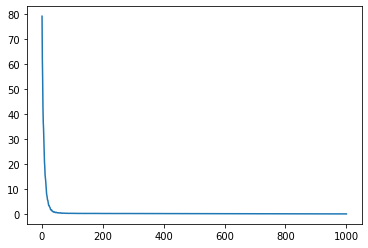

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


model = models.Sequential()
model.add(layers.Dense(50, activation = 'relu', input_shape = (11, )))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()
model.compile(
loss = 'sparse_categorical_crossentropy',
optimizer = 'Adam',
metrics=["accuracy"],
)
history = model.fit(X_train, y_train, batch_size=1000, epochs=1000, validation_split=0.2, validation_data = (X_test, y_test))
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])
history_dict = history.history
loss_values = history_dict['loss']
epocks = range(1, len(loss_values) + 1)
plt.plot(epocks, loss_values)
plt.show()
